In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import torch
import random

2024-04-05 19:38:30.408027: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Generation

In [2]:
max_moves = 1000  #how many inverse operations on the final destination
goal_position = torch.tensor([[1], [0]], dtype=torch.float64) #start with a 2 x 1 

def data_generator(matrix_T, matrix_U, num_of_datapoints):
    inverse_U = torch.inverse(matrix_U)
    data = torch.empty((num_of_datapoints, 3), dtype=torch.int32)
    for i in range(num_of_datapoints):
        start = goal_position
        moves = random.randint(1, max_moves)
        coin = random.randint(0, 1)
        prev_coin = -1
        for q in range(moves):
            if coin == 0:
                start = torch.matmul(matrix_T, start)
                prev_coin = coin
                coin = random.randint(0, 1)
                while coin == 0: 
                    coin = random.randint(0, 1)
            else:
                #  print(start, inverse_T, "=")
                start = torch.matmul(matrix_U, start)
                prev_coin = coin
                coin = random.randint(0, 1)
                while coin == 1: 
                    coin = random.randint(0, 1)
            # print(start)
        # print("done")
        data[i, 0] = start[0]
        data[i, 1] = start[1]
        data[i, 2] = prev_coin
    return data

#https://stackoverflow.com/questions/36158058/torch-save-tensor-to-csv-file#:~:text=For%20simple%20tables%2C%20you%20can,then%20to%20a%20Pandas%20dataframe.&text=You%20can%20first%20convert%20the,table%20as%20a%20csv%20file.

matrix_T = torch.tensor([[0, 1], [1, 0]], dtype=torch.float64)
matrix_U = torch.tensor([[1, -1], [0, 1]], dtype=torch.float64)

data = data_generator(matrix_T, matrix_U, 10000)
data_table = data.numpy()

x_train = data_table[:, :-1]
y_train_number = data_table[:, -1]

# matrix_T = torch.tensor([[0, -1], [1, 0]], dtype=torch.float64)
# matrix_U = torch.tensor([[1, 1], [0, 1]], dtype=torch.float64)

data = data_generator(matrix_T, matrix_U, 10000)
data_table = data.numpy()

x_test = data_table[:, :-1]
y_test_number = data_table[:, -1]

In [3]:
y_test_number

array([1, 0, 1, ..., 1, 0, 0], dtype=int32)

In [4]:
def find_index(arr, target):
    for i in range(len(arr)):
        if arr[i] == target:
            return i
    # If the target is not found in the array, return -1
    return -1

# Example usage:
my_array = y_test_number
target_number = 1
index = find_index(my_array, target_number)
if index != -1:
    print(f"The index of {target_number} in the array is: {index}")
else:
    print(f"{target_number} is not found in the array.")


The index of 1 in the array is: 0


In [5]:
def count_condition_occurrences(data_table):
    count = 0
    total = 0 
    for row in data_table:
        if row[0] > row[1] and row[2] == 1:
            count += 1
        total += 1
    return count, total


occurrences, total = count_condition_occurrences(data_table)
print("Number of occurrences:", occurrences, "out of: ", total)


Number of occurrences: 206 out of:  10000


## Helper Functions

In [6]:
# One hot encoding 
# some parts from chat GPT 
y_train = []

def one_hot_encode(number):
    if number < 0 or number > 1:
        raise ValueError("Number must be between 0 and 3.")
    
    encoding = np.zeros((1, 2))  # Initialize the encoding vector with all zeros
    encoding[0][number] = 1    # Set the value at the index corresponding to the number to 1
    return encoding

for i in range(len(y_train_number)):
    y_train.append(one_hot_encode(y_train_number[i]))

# Convert the list to a NumPy array
y_train = np.array(y_train)
y_train = y_train.reshape((len(y_train_number), 2))

y_test = []

def one_hot_encode(number):
    if number < 0 or number > 1:
        raise ValueError("Number must be between 0 and 3.")
    
    encoding = np.zeros((1, 2))  # Initialize the encoding vector with all zeros
    encoding[0][number] = 1    # Set the value at the index corresponding to the number to 1
    return encoding

for i in range(len(y_test_number)):
    y_test.append(one_hot_encode(y_test_number[i]))

# Convert the list to a NumPy array
y_test = np.array(y_test)
y_test = y_test.reshape((len(y_test_number), 2))

In [7]:
def lr_schedule(epoch, lr: float) -> float:
    if epoch == 25:
        return lr * .75
    if epoch == 50:
        return lr * .75
    if epoch == 75:
        return lr * .75
    # if epoch == 100: 
    #     return lr * .75    
    # if epoch == 125: 
    #     return lr * .75
    # if epoch == 150: 
    #     return lr * .75  
    # if epoch == 175: 
    #     return lr * .75
    # if epoch == 200: 
    #     return lr * .75  
    # if epoch == 225: 
    #     return lr * .75
    # if epoch == 250: 
    #     return lr * .75  
    # if epoch == 275: 
    #     return lr * .75
    # if epoch == 300: 
    #     return lr * .75
    # if epoch == 325: 
    #     return lr * .75
    # if epoch == 350: 
    #     return lr * .75  
    # if epoch == 375: 
    #     return lr * .75
    # if epoch == 400: 
    #     return lr * .75
    # if epoch == 425: 
    #     return lr * .75
    # if epoch == 450: 
    #     return lr * .75  
    # if epoch == 475: 
    #     return lr * .75  
    return lr

## Model Definition

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation

#
model = Sequential()
model.add(Dense(128, input_dim=2, activation = 'sigmoid'))
model.add(Dense(64,  activation = 'sigmoid'))
model.add(Dense(16, activation = 'sigmoid'))
model.add(Dense(2, activation = 'softmax'))

# From GPT to save the best performing weights
model_checkpoint_callback = ModelCheckpoint(
    filepath='checkpoint_model.h5',  # Path where to save the model
    save_best_only=True,               # Only save a model if `val_loss` has improved
    monitor='loss',                # Monitor validation loss for improvement
    mode='min',                        # The lower the `val_loss`, the better
    verbose=1)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003, use_ema=True,
    ema_momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## Training And Output

In [10]:
model.fit(x_train, y_train, epochs=500, batch_size=100)

Epoch 1/500
100/100 [==============================] - 2s 3ms/step - loss: 0.6905 - accuracy: 0.5207
Epoch 2/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5455
Epoch 3/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.5490
Epoch 4/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.5448
Epoch 5/500
100/100 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.5584
Epoch 6/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.5502
Epoch 7/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.5455
Epoch 8/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.5490
Epoch 9/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.5460
Epoch 10/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6287 - accura

In [11]:
score = model.evaluate(x_test, y_test, batch_size=100)
print(score[0])
print(score[1])

100/100 [==============================] - 0s 1ms/step - loss: 0.6292 - accuracy: 0.5430
0.6292226314544678
0.5429999828338623


In [12]:
model.save('new_full_model.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Learned Descision Boundary

1/1 [==============================] - 0s 85ms/step


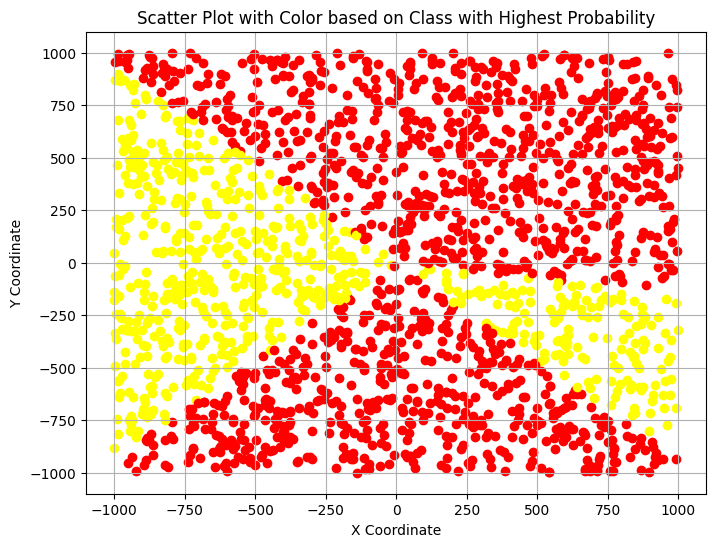

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x = random.randint(-1000, 1000)
y = random.randint(-1000, 1000)

# Example model output with shape (100, 4)
model_output = model.predict(torch.tensor([[x, y]]).numpy())  # Example model output with shape (100, 4)


# Scatter plot
plt.figure(figsize=(8, 6))

# Iterate over the loop to generate coordinates one at a time
for i in range(2000):
    # Generate x and y coordinates one at a time
    x = random.randint(-1000, 1000)
    y = random.randint(-1000, 1000)

# Example model output with shape (100, 4)
    #print(x, y)
    model_output = model.predict(torch.tensor([[x, y]]).numpy(), verbose=0)  # Example model output with shape (100, 4)
    
    # Find the index of the maximum probability for this point
    max_prob_index = np.argmax(model_output)
    #print(model_output, max_prob_index)
    
    # Plot the point with color based on the class with highest probability
    col = 'blue'
    if (max_prob_index == 0):
        col = 'red'
    elif (max_prob_index == 1):
        col = 'yellow'
    elif (max_prob_index == 2):
        col = 'blue'
    plt.scatter(x, y, c=col)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot with Color based on Class with Highest Probability')
plt.grid(True)
plt.show()
